In [1]:
import os
os.chdir(os.path.abspath(".."))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

from dataio import load_metadataset, load_accs
from metamodel import build_baseline, build_classification_topline

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from MCM import MCM

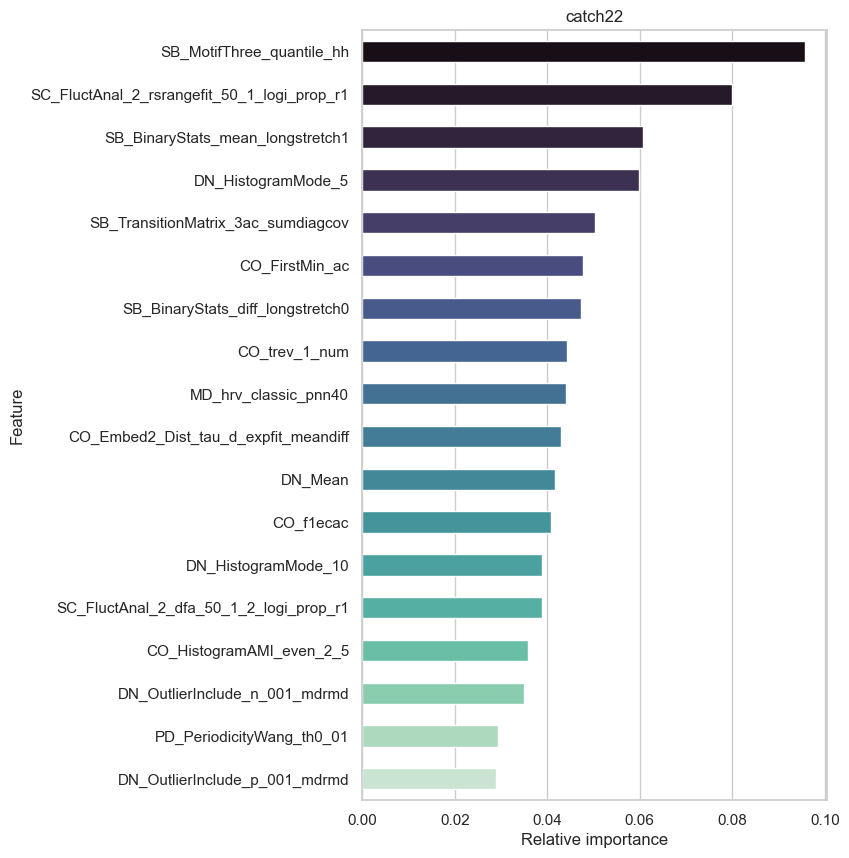

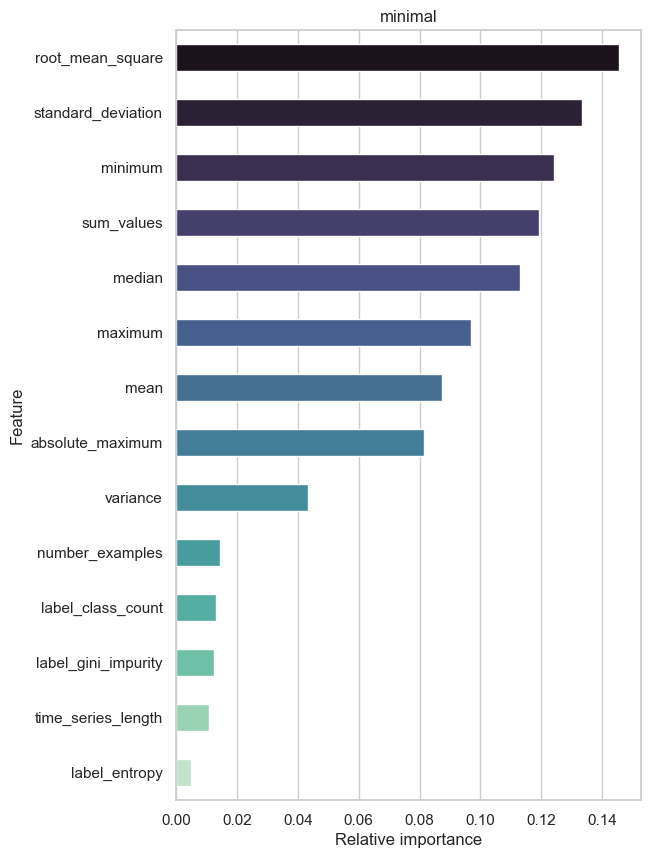

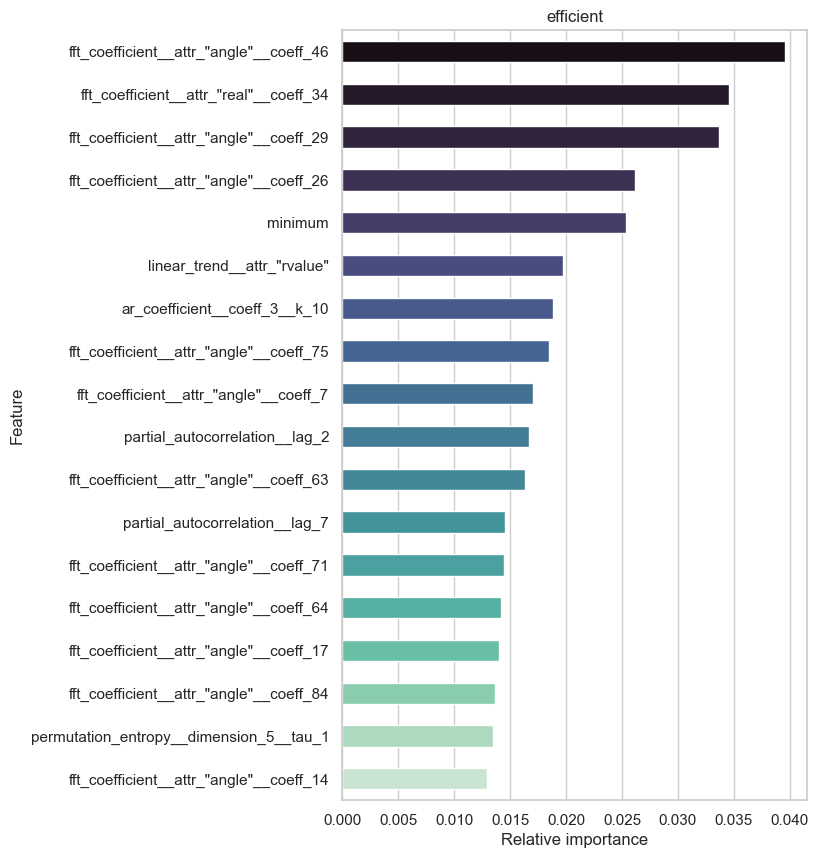

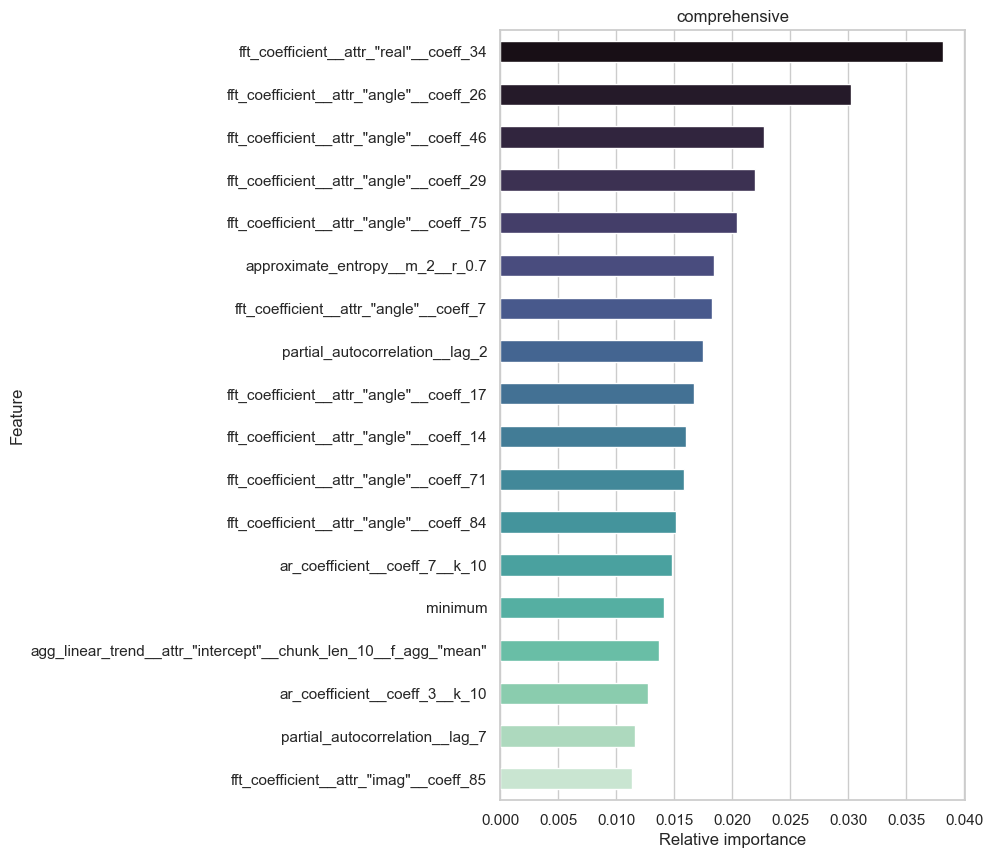

In [3]:
sns.set_theme(style="whitegrid")

feature_set_importances = dict()

for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    meta_X, meta_y = load_metadataset(feature_set, problem_type="classification")
    y_encoder = LabelEncoder().fit(meta_y)
    meta_y_encoded = y_encoder.transform(meta_y)

    xgb = XGBClassifier().fit(meta_X, meta_y_encoded)
    feature_importances = xgb.feature_importances_
    
    importance_map = dict()
    for fname, fimp in zip(meta_X.columns, feature_importances):
        fname_split = fname.split("_")
        if fname_split[0] in ["mean", "std", "median", "q1", "q3", "max", "min"]:
            fname_proper = "_".join(fname_split[1:])
            importance_map[fname_proper] = fimp + importance_map.get(fname_proper, 0.)
        else:
            importance_map[fname] = fimp + importance_map.get(fname, 0.)

    imps = np.array(list(importance_map.values()))
    names = np.array(list(importance_map.keys()))
    order = np.argsort(-imps)

    feature_set_importances[feature_set] = {
        "name": names[order],
        "importance": imps[order]
    }

n_features = 18
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    fig, ax = plt.subplots(figsize=(6, 10))

    sns.barplot(
        x=feature_set_importances[feature_set]["importance"][:n_features],
        y=feature_set_importances[feature_set]["name"][:n_features],
        palette="mako",
        width=0.5,
        ax=ax
    )
    ax.set_xlabel("Relative importance")
    ax.set_ylabel("Feature")
    ax.set_title(feature_set)

    plt.show()

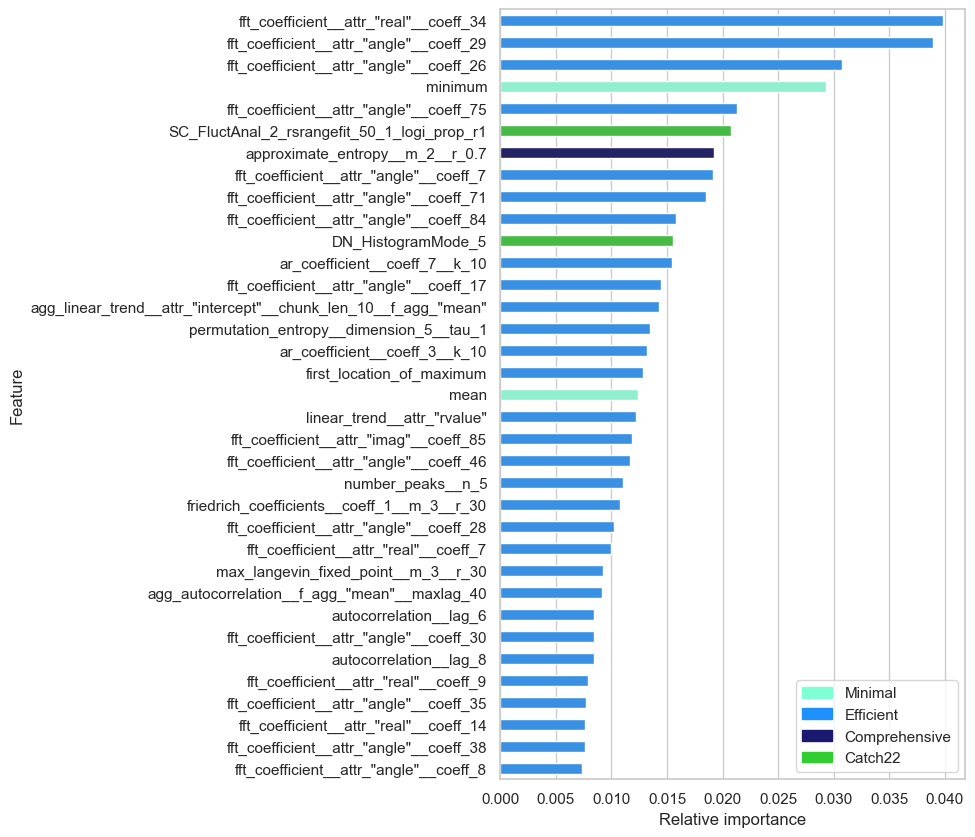

In [4]:
meta_X_tsfresh, meta_y = load_metadataset("comprehensive", "classification")
meta_X_catch22, _ = load_metadataset("catch22", "classification")
meta_X = pd.concat([meta_X_tsfresh, meta_X_catch22], axis=1)
meta_X = meta_X.T.drop_duplicates().T

y_encoder = LabelEncoder().fit(meta_y)
meta_y_encoded = y_encoder.transform(meta_y)

xgb = XGBClassifier().fit(meta_X, meta_y_encoded)
feature_importances = xgb.feature_importances_

importance_map = dict()
for fname, fimp in zip(meta_X.columns, feature_importances):
    fname_split = fname.split("_")
    if fname_split[0] in ["mean", "std", "median", "q1", "q3", "max", "min"]:
        fname_proper = "_".join(fname_split[1:])
        importance_map[fname_proper] = fimp + importance_map.get(fname_proper, 0.)
    else:
        importance_map[fname] = fimp + importance_map.get(fname, 0.)

imps = np.array(list(importance_map.values()))
names = np.array(list(importance_map.keys()))
order = np.argsort(-imps)

hue = list()
for name in names:
    if name in ["number_examples", "time_series_length"]:
        hue.append("General")
    elif name.startswith("label_"):
        hue.append("Label")
    elif name in feature_set_importances["catch22"]["name"]:
        hue.append("Catch22")
    elif name in feature_set_importances["minimal"]["name"]:
        hue.append("Minimal")
    elif name in feature_set_importances["efficient"]["name"]:
        hue.append("Efficient")
    else:
        hue.append("Comprehensive")
hue = np.array(hue)
colors = {
    "Minimal": "aquamarine",
    "Efficient": "dodgerblue",
    "Comprehensive": "midnightblue",
    "Catch22": "limegreen",
    #"General": "red",
    #"Label": "magenta"
}

n_features = 35
fig, ax = plt.subplots(figsize=(6, 10))
sns.barplot(
    x=imps[order][:n_features],
    y=names[order][:n_features],
    width=0.5,
    palette=[colors[h] for h in hue[order][:n_features]],
    ax=ax
)
ax.set_xlabel("Relative importance")
ax.set_ylabel("Feature")
ax.legend(
    [plt.Rectangle((0,0), 1, 1, color=colors[label]) for label in colors.keys()],
    colors.keys()
)

plt.show()

In [6]:
print("--- Best estimator accuracies ---")

for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    accs = np.empty(5)
    for i in range(5):
        results = pd.read_csv(f"./results/classification/{feature_set}/xgb/classification_label_{feature_set}_xgb_{i+1}.csv")
        accs[i] = accuracy_score(results["best_estimator"], results["predicted_estimator"])
    
    print(f"{feature_set}: {100 * np.mean(accs):.5f}%")

--- Best estimator accuracies ---
catch22: 35.21127%
minimal: 30.98592%
efficient: 30.98592%
comprehensive: 27.46479%


In [8]:
results = dict()
accs = load_accs()
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    acc = None
    for i in range(5):
        res = pd.read_csv(f"./results/classification/{feature_set}/xgb/classification_label_{feature_set}_xgb_{i+1}.csv")
        if acc is None:
            acc = res["acc"]
        else:
            acc = acc + res["acc"]
    acc = acc / 5

    results[feature_set] = acc

results["datasets"] = res["dataset"]
results["baseline"] = build_baseline(accs)
results["topline"] = build_classification_topline(accs) + 1e-15

results = pd.DataFrame(results).set_index("datasets")
results

,catch22,minimal,efficient,comprehensive,baseline,topline
datasets,,,,,,
ACSF1,0.843667,0.826667,0.843667,0.843667,0.803125,0.843667
AconityMINIPrinterLargeEq,0.954673,0.954673,0.954673,0.954673,0.948582,0.965512
AconityMINIPrinterSmallEq,0.972831,0.972831,0.972831,0.972831,0.973816,0.977968
Adiac,0.824467,0.824467,0.824467,0.824467,0.792647,0.824467
AllGestureWiimoteXEq,0.818333,0.818333,0.765286,0.765286,0.734196,0.818333
...,...,...,...,...,...,...
Wine,0.957407,0.947531,0.856173,0.856173,0.912346,0.957407
WordSynonyms,0.786886,0.786886,0.786886,0.752090,0.738532,0.786886
Worms,0.760173,0.760173,0.760173,0.760173,0.742749,0.780952


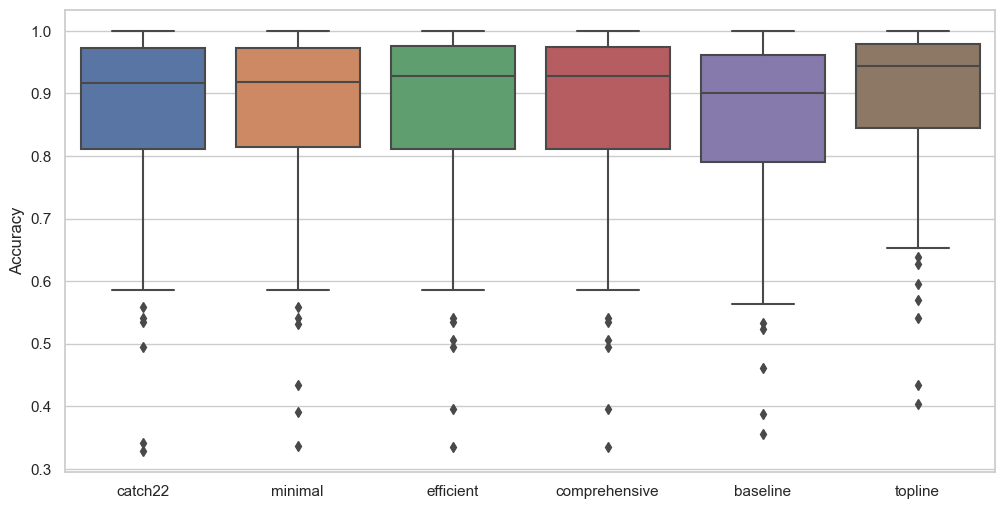

In [9]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(data=results, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Accuracy")

plt.show()

Processing topline, baseline:   0%|          | 0/6 [00:00<?, ?it/s]       


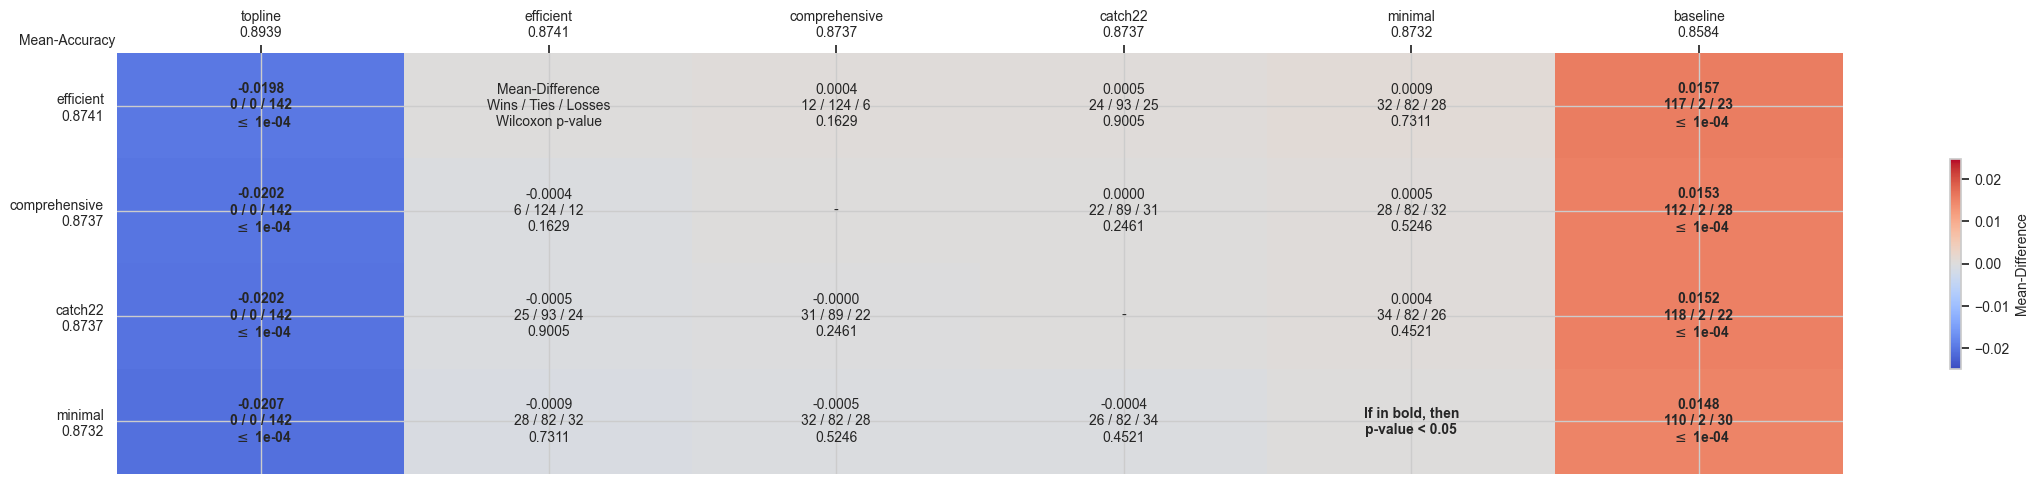

In [10]:
MCM.compare(
    df_results=results,
    output_dir="results/",
    used_statistic="Accuracy",
    order_WinTieLoss="higher",
    order_better="decreasing",
    save_as_json=False,
    win_label="Wins",
    tie_label="Ties",
    loss_label="Losses",
    colormap="coolwarm",
    excluded_row_comparates=["baseline", "topline"],
)

In [12]:
print("--- Metamodel accuracies ---")
for model in ["svm", "nb", "1nn", "5nn"]:
    res = pd.read_csv(f"results/classification/catch22/classification_label_catch22_{model}.csv")
    print(f"{model}: {100 * accuracy_score(res['best_estimator'], res['predicted_estimator']):.5f}%")

for model in ["rf", "xgb"]:
    acc = 0.
    for i in range(5):
        res = pd.read_csv(f"results/classification/catch22/{model}/classification_label_catch22_{model}_{i+1}.csv")
        acc += accuracy_score(res['best_estimator'], res['predicted_estimator'])
    acc /= 5
    print(f"{model}: {100 * acc:.5f}%")

--- Metamodel accuracies ---
svm: 33.80282%
nb: 18.30986%
1nn: 26.76056%
5nn: 30.28169%
rf: 35.91549%
xgb: 35.21127%


In [13]:
results = dict()
for model in ["svm", "nb", "1nn", "5nn"]:
    res = pd.read_csv(f"results/classification/catch22/classification_label_catch22_{model}.csv")
    results[model] = res["acc"]

for model in ["rf", "xgb"]:
    acc = None
    for i in range(5):
        res = pd.read_csv(f"results/classification/catch22/{model}/classification_label_catch22_{model}_{i+1}.csv")
        if acc is None:
            acc = res["acc"]
        else:
            acc = acc + res["acc"]
    acc = acc / 5
    results[model] = acc

rmses = load_accs()
results["datasets"] = rmses.columns

results = pd.DataFrame(results).set_index("datasets")
results

,svm,nb,1nn,5nn,rf,xgb
datasets,,,,,,
Adiac,0.843667,0.800000,0.800000,0.800000,0.826200,0.843667
ArrowHead,0.954673,0.943328,0.954673,0.958164,0.954673,0.954673
Beef,0.972831,0.972831,0.972831,0.977511,0.972831,0.972831
BeetleFly,0.824467,0.817818,0.824467,0.824467,0.824467,0.824467
BirdChicken,0.818333,0.688238,0.818333,0.818333,0.818333,0.818333
...,...,...,...,...,...,...
PickupGestureWiimoteZEq,0.936420,0.957407,0.928395,0.957407,0.940617,0.957407
PLAIDEq,0.786886,0.750784,0.786886,0.786886,0.786886,0.786886
ShakeGestureWiimoteZEq,0.760173,0.722511,0.760173,0.738528,0.760173,0.760173


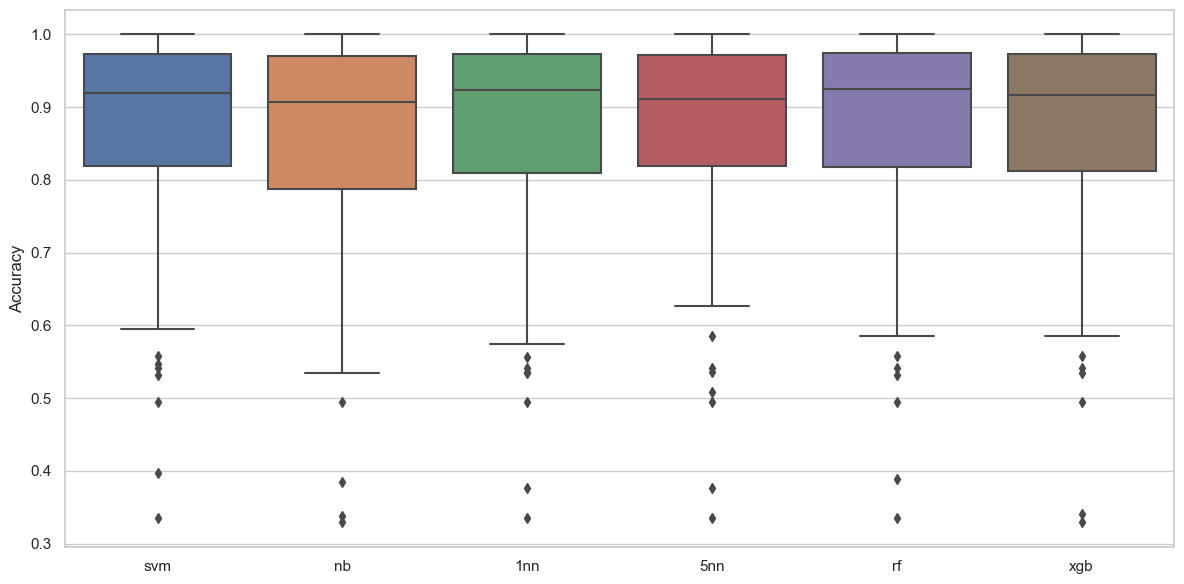

In [14]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(data=results, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Accuracy")

plt.show()

Processing xgb, rf:   0%|          | 0/6 [00:00<?, ?it/s] 


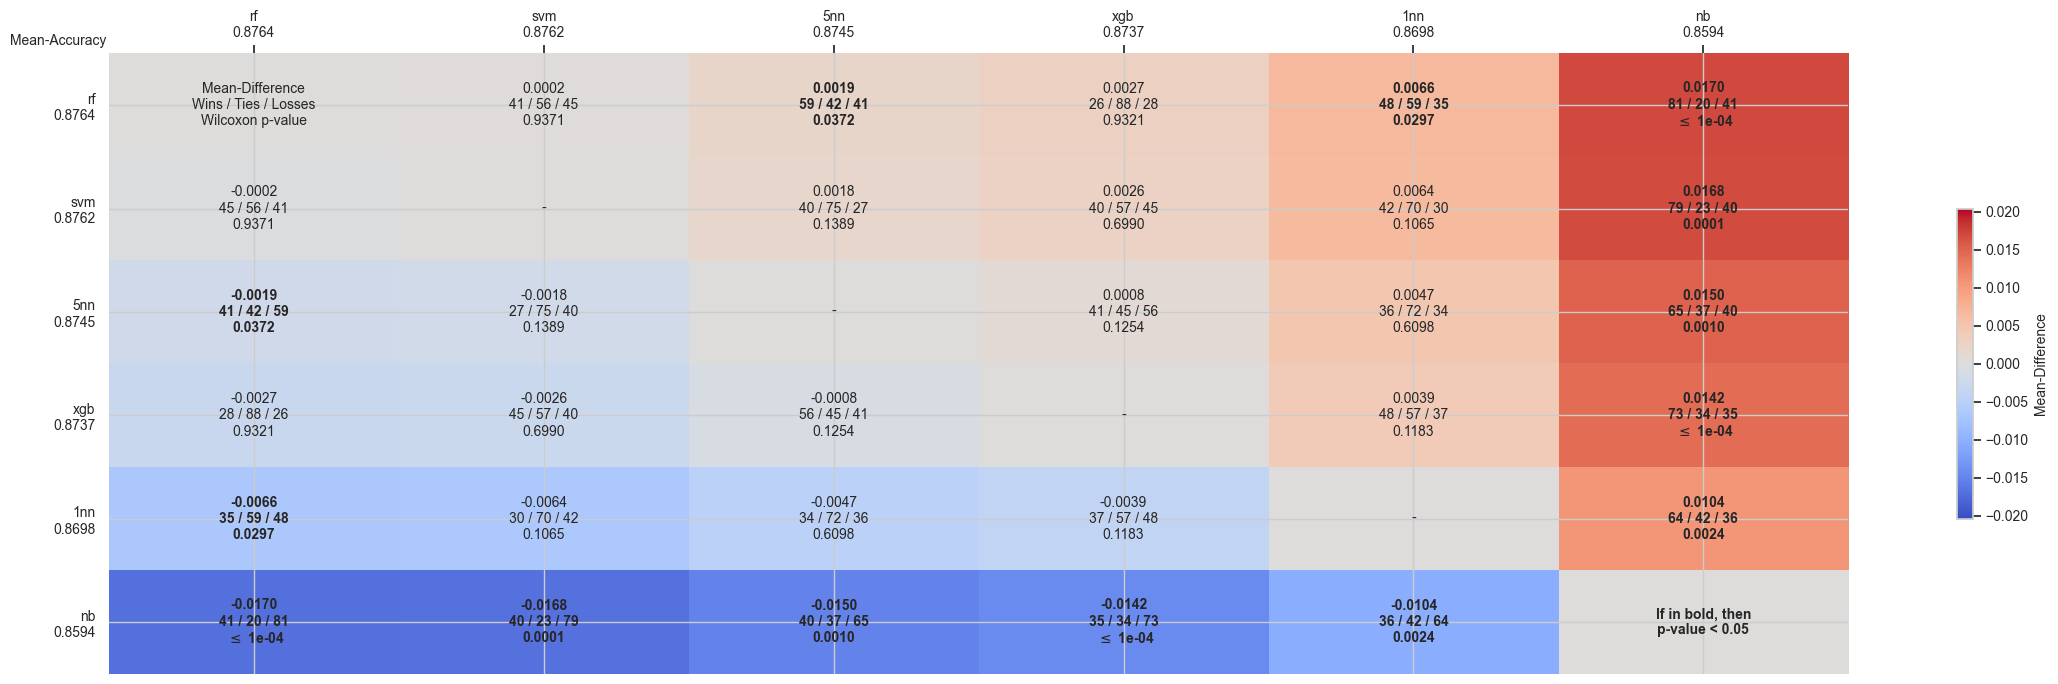

In [15]:
MCM.compare(
    df_results=results,
    output_dir="results/",
    used_statistic="Accuracy",
    order_WinTieLoss="higher",
    order_better="decreasing",
    save_as_json=False,
    win_label="Wins",
    tie_label="Ties",
    loss_label="Losses",
    colormap="coolwarm",
)